In [150]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr, ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, explained_variance_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.feature_selection import RFE, SelectKBest, f_regression

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

import acquire
#import prepare
#import explore

# Goal <br>
The goal of this project is to identify predictive features for the value of properties. <br>
Area (sqft), number of bedrooms, and number of bathrooms are likely to influence property values.

# Acquire

In [2]:
df = acquire.get_zillow_data()
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


In [3]:
df.shape

(2152863, 7)

In [4]:
df.dtypes

bedroomcnt                      float64
bathroomcnt                     float64
calculatedfinishedsquarefeet    float64
taxvaluedollarcnt               float64
yearbuilt                       float64
taxamount                       float64
fips                            float64
dtype: object

In [5]:
df.isna().sum()

bedroomcnt                        11
bathroomcnt                       11
calculatedfinishedsquarefeet    8484
taxvaluedollarcnt                493
yearbuilt                       9337
taxamount                       4442
fips                               0
dtype: int64

# Prepare

Look at tax rates by county.

In [6]:
def get_tax_info(df):
    # This is the columns that will be used to predict tax rate by county
    tax_info = df[['taxamount', 'taxvaluedollarcnt', 'fips']]
    
    tax_info = tax_info.dropna()
    
    # This reduces our dataset to 1000 randomly selected rows
    # The original dataset has too many points to easily plot
    tax_info = tax_info.sample(n=1000, axis=0)
    
    # This is the tax rate
    tax_info['tax_rates'] = round((df.taxamount / df.taxvaluedollarcnt) * 100, 2)
    
    # Setting up tax rates by county from fips
    los_angeles = tax_info[tax_info.fips == 6037].tax_rates
    orange = tax_info[tax_info.fips == 6059].tax_rates
    ventura = tax_info[tax_info.fips == 6111].tax_rates
    
    # Now to plot the tax rates by county
    plt.figure(figsize = (10, 5))

    plt.subplot(311)
    plt.hist(los_angeles, bins = 100)
    plt.title('Los Angeles County Tax Rates')
    plt.xlabel('Tax Rates (%)')
    plt.ylabel('Frequency')

    plt.subplot(312)
    plt.hist(orange, bins = 100)
    plt.title('Orange County Tax Rates')
    plt.xlabel('Tax Rates (%)')
    plt.ylabel('Frequency')

    plt.subplot(313)
    plt.hist(ventura, bins = 100)
    plt.title('Ventura County Tax Rates')
    plt.xlabel('Tax Rates (%)')
    plt.ylabel('Frequency')

    plt.subplots_adjust(bottom=3, top=7)

    plt.show()
    
    return tax_info

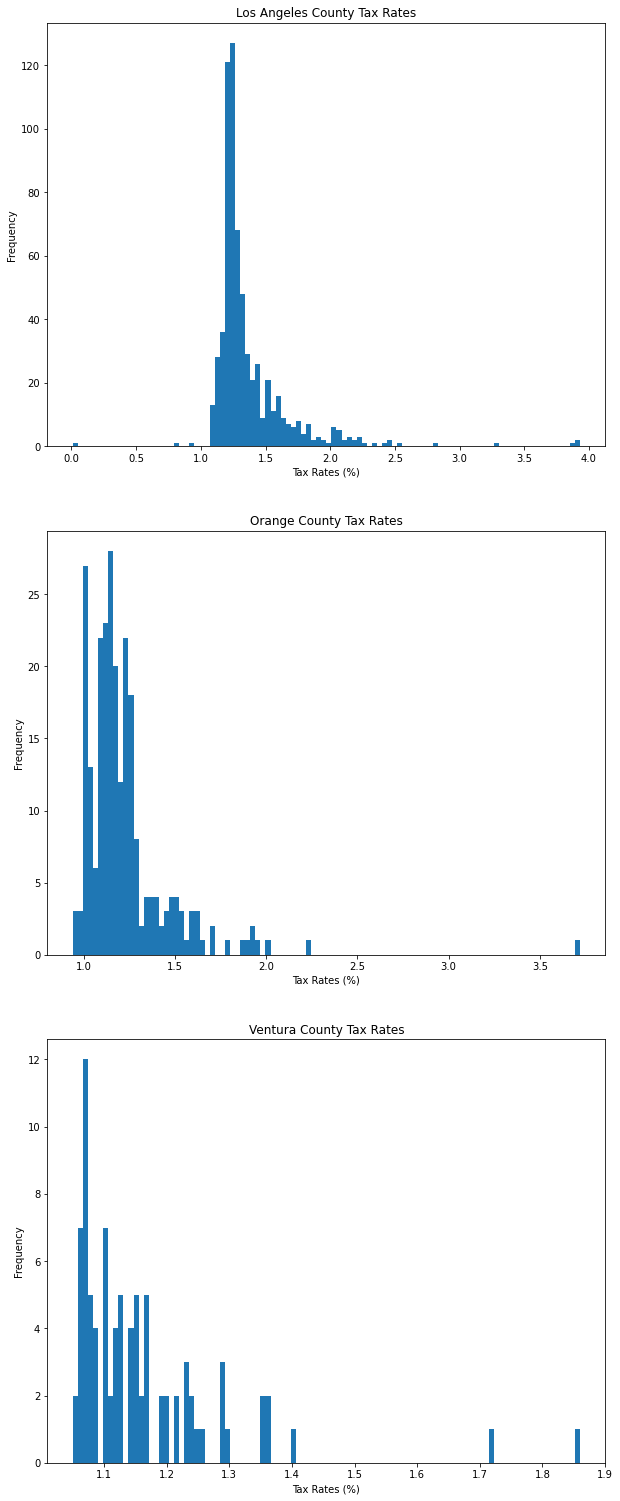

In [7]:
tax_info = get_tax_info(df)

In [12]:
def prepare_zillow(df):
    '''
    This prepares zillow df for analysis.
    Only the features needed for MVP are kept.
    Columns are given more meaningfull names.
    Nulls are dropped.
    Properties without bedrooms or bathrooms are dropped.
    '''
    
    # Get dataframe with only features needed for the MVP
    zillow = df[['calculatedfinishedsquarefeet', 'bedroomcnt', 'bathroomcnt', 
                 'taxvaluedollarcnt']]

    # Give column more meaningful names
    zillow = zillow.rename(columns={'calculatedfinishedsquarefeet':'area', 
                                    'bedroomcnt':'bedroom', 
                                    'bathroomcnt':'bathroom', 
                                    'taxvaluedollarcnt':'taxvalue'})

    # Drop rows with null values
    zillow = zillow.dropna()

    # Drop properties with no bedrooms or bathrooms
    zillow = zillow[zillow.bedroom > 0]
    zillow = zillow[zillow.bathroom > 0]
    
    return zillow

In [16]:
zillow = prepare_zillow(df)
zillow.head()

,area,bedroom,bathroom,taxvalue
4,3633.0,4.0,2.0,296425.0
6,1620.0,3.0,4.0,847770.0
7,2077.0,3.0,2.0,646760.0
18,1244.0,3.0,1.0,169471.0
19,1300.0,3.0,2.0,233266.0


In [17]:
def zillow_split(zillow):
    '''
    This function splits the df into train, validate, and test subsets.
    '''
    # Split the data into train, validate, test, subsets
    train_validate, test = train_test_split(zillow, test_size=.2, random_state=123)
    train, validate = train_test_split(zillow, test_size=.25, random_state=123)

    return train, validate, test

In [19]:
train, validate, test = zillow_split(zillow)
train.shape, validate.shape, test.shape

((1603806, 4), (534602, 4), (427682, 4))

In [20]:
train.head()

,area,bedroom,bathroom,taxvalue
712535,1182.0,3.0,1.0,170555.0
1595009,804.0,2.0,1.0,619302.0
2010309,2534.0,4.0,3.0,353679.0
1076111,1485.0,3.0,2.0,344602.0
1233651,1418.0,3.0,2.0,486048.0


# Explore

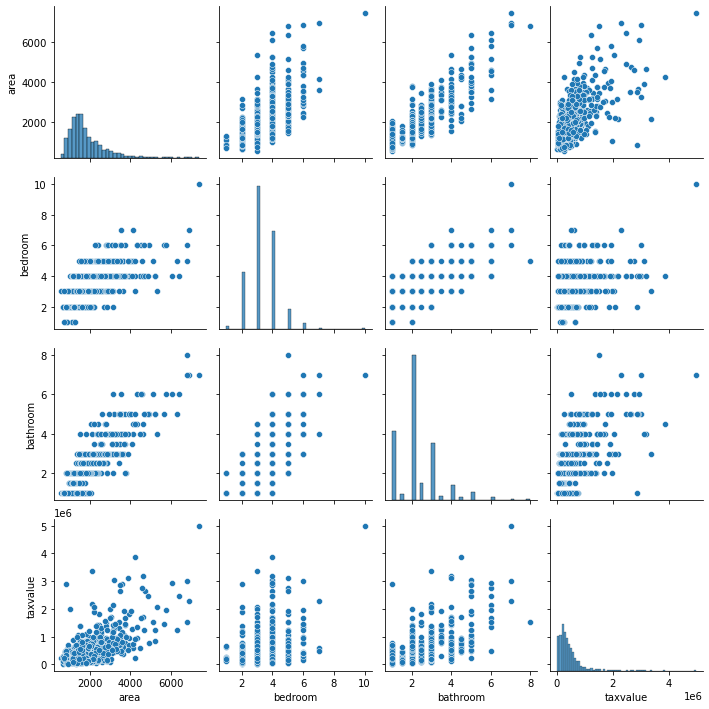

In [21]:
# Explore the train subset
# The train subset is too big to easily plot it, so I will randomly pick 1000 rows
train_sampled = train.sample(n=1000, axis=0)

sns.pairplot(train_sampled)

In [22]:
# This tells us which features are correlated with taxvalue
train_sampled.corr()

,area,bedroom,bathroom,taxvalue
area,1.000000,0.651563,0.865334,0.662269
bedroom,0.651563,1.000000,0.668550,0.332955
bathroom,0.865334,0.668550,1.000000,0.602251
taxvalue,0.662269,0.332955,0.602251,1.000000


In [100]:
# Correlation tests are used to check if two features are correlated
r, p = pearsonr(train.taxvalue, train.area)
r,p

(0.48045569760299606, 0.0)

In [101]:
r, p = pearsonr(train.taxvalue, train.bedroom)
r,p

(0.2587995566753232, 0.0)

In [102]:
r, p = pearsonr(train.taxvalue, train.bathroom)
r,p

(0.5049545378429363, 0.0)

In [105]:
f, p = ttest_ind(train.taxvalue, train.area)
f, p

(856.4625199413069, 0.0)

In [106]:
f, p = ttest_ind(train.taxvalue, train.bedroom)
f, p

(859.9344893881657, 0.0)

In [107]:
f, p = ttest_ind(train.taxvalue, train.bathroom)
f, p

(859.9364716586346, 0.0)

# Model & Evaluate

Scale the predictive features, but not the target

In [108]:
# Create subsets with only predictive features (x)
# Create subsets with only target feature (y)
x_train = train.drop(columns='taxvalue')
y_train = train.taxvalue
x_validate = train.drop(columns='taxvalue')
y_validate = train.taxvalue
x_test = train.drop(columns='taxvalue')
y_test = train.taxvalue

In [109]:
def zillow_scale(train, validate, test):
    '''
    This function scales data after it has been split into train, validate, and test subsets.
    '''
   
    # Create the scaler object
    scaler = MinMaxScaler()

    # Fit the scaler
    scaler.fit(x_train)

    # Use the scaler
    x_train_scaled = scaler.transform(x_train)
    x_validate_scaled = scaler.transform(x_validate)
    x_test_scaled = scaler.transform(x_test)

    return x_train_scaled, x_validate_scaled, x_test_scaled

In [110]:
x_train_scaled, x_validate_scaled, x_test_scaled = zillow_scale(train, validate, test)
x_train_scaled.shape, x_validate_scaled.shape, x_test_scaled.shape

((1603806, 3), (1603806, 3), (1603806, 3))

In [111]:
y_train.shape, y_validate.shape, y_test.shape

((1603806,), (1603806,), (1603806,))

### Using Kbest to identify importance of features

In [112]:
def select_kbest(x_train_scaled, y_train, k):
    '''
    This function takes predictive features (x_train), target features (y_train), 
    and the number of top features (k) that we want to select.
    It returns the top predictive features that correlate with the target.
    '''
    
    # Create the object
    kbest = SelectKBest(f_regression, k)
    
    # Fit the object
    kbest = best.fit(x_train_scaled, y_train)

    # Convert back into a pd dataframe
    x_train_scaled = pd.DataFrame(x_train_scaled)

    # Return the columns names back to their original names (names were lost when kbest converted them into series)
    x_train_scaled.columns = x_train.columns

    # Use the object
    kbest = x_train.columns[kbest.get_support()]
    
    return kbest

In [113]:
kbest = select_kbest(x_train_scaled, y_train, 1)
kbest

Index(['bathroom'], dtype='object')

### Using RFE to identify importance of features

In [114]:
def select_rfe(x_train_scaled, y_train, k):
    '''
    This function uses RFE to find the best predictive features
    for the target.
    '''
    
    rfe = RFE(estimator=LinearRegression(), n_features_to_select=k)
    rfe.fit(x_train_scaled, y_train)
    rfe.get_support()
    rfe_best = x_train.columns[rfe.get_support()]
    
    return rfe_best

In [115]:
k=1
rfe_best = select_rfe(x_train_scaled, y_train, k)
rfe_best

Index(['area'], dtype='object')

In [126]:
# Convert target series back into pd dataframe
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

y_train.head()

,taxvalue,price_pred_mean,price_pred_lm,price_pred_lars
712535,170555.0,460986.858177,1.713151e+11,39065.512928
1595009,619302.0,460986.858177,1.165320e+11,78937.429111
2010309,353679.0,460986.858177,3.672831e+11,706742.898728
1076111,344602.0,460986.858177,2.152394e+11,365014.848149
1233651,486048.0,460986.858177,2.055288e+11,354882.803820


### Creating a baseline model

In [145]:
# Create a mean baseline
# Baseline is the median even though it says mean, so I don't have to make many changes
price_pred_m = y_train.taxvalue.median()
y_train['price_pred_mean'] = price_pred_mean
y_validate['price_pred_mean'] = price_pred_mean
y_test['price_pred_mean'] = price_pred_mean

y_train.head()

,taxvalue,price_pred_mean,price_pred_lm,price_pred_lars,price_pred_glm
712535,170555.0,460986.858177,1.713151e+11,39065.512928,460986.858177
1595009,619302.0,460986.858177,1.165320e+11,78937.429111,460986.858177
2010309,353679.0,460986.858177,3.672831e+11,706742.898728,460986.858177
1076111,344602.0,460986.858177,2.152394e+11,365014.848149,460986.858177
1233651,486048.0,460986.858177,2.055288e+11,354882.803820,460986.858177


In [154]:
# RMSE of price_pred_mean (mean baseline)
rmse_train = mean_squared_error(y_train.taxvalue,
                                y_train.price_pred_mean) ** .5

rmse_validate = mean_squared_error(y_validate.taxvalue, 
                                   y_validate.price_pred_mean) ** .5

rmse_test = mean_squared_error(y_test.taxvalue, 
                                   y_validate.price_pred_mean) ** .5

r2_train = explained_variance_score(y_train.taxvalue, y_train.price_pred_mean)
r2_validate = explained_variance_score(y_validate.taxvalue, y_validate.price_pred_mean)


print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2), 
      "\n",
      "\n",
      "R^2 using Mean\nTrain/In-Sample: ", round(r2_train, 2),
      "\nValidate/Out-of-Sample: ", round(r2_validate, 2)
     )


RMSE using Mean
Train/In-Sample:  678884.42 
Validate/Out-of-Sample:  678884.42 
 
 R^2 using Mean
Train/In-Sample:  0.0 
Validate/Out-of-Sample:  0.0


### Creating a linear regression model

In [160]:
# Linear regression, OLS

# Create the object
lm = LinearRegression(normalize=True)

# Fit the object
lm.fit(x_train_scaled, y_train.taxvalue)

# Use the object
y_train['price_pred_lm'] = lm.predict(x_train)
rmse_train = mean_squared_error(y_train.taxvalue, y_train.price_pred_lm) ** (1/2)

y_validate['price_pred_lm'] = lm.predict(x_validate)
rmse_validate = mean_squared_error(y_validate.taxvalue, y_validate.price_pred_lm) ** (1/2)

r2_train = explained_variance_score(y_train.taxvalue, y_train.price_pred_lm)
r2_validate = explained_variance_score(y_validate.taxvalue, y_validate.price_pred_lm)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
      "\n",
      "\n",
      "R^2 using Mean\nTrain/In-Sample: ", round(r2_train, 2),
      "\nValidate/Out-of-Sample: ", round(r2_validate, 2))

RMSE for OLS using LinearRegression
Training/In-Sample:  322953489728.15857 
Validation/Out-of-Sample:  322953489728.15857 
 
 R^2 using Mean
Train/In-Sample:  -67965297701.0 
Validate/Out-of-Sample:  -67965297701.0


### Creating a LassoLars model

In [161]:
# Create the object
lars = LassoLars(alpha=1)

# Fit the model to train. 
# We must specify the column in y_train, 
# because we have converted it to a dataframe from a series!
lars.fit(x_train, y_train.taxvalue)

# predict train
y_train['price_pred_lars'] = lars.predict(x_train)

# evaluate using rmse
rmse_train = mean_squared_error(y_train.taxvalue, y_train.price_pred_lars) ** (1/2)

# predict validate
y_validate['price_pred_lars'] = lars.predict(x_validate)

# evaluate using rmse
rmse_validate = mean_squared_error(y_validate.taxvalue, y_validate.price_pred_lars) ** (1/2)

r2_train = explained_variance_score(y_train.taxvalue, y_train.price_pred_lars)
r2_validate = explained_variance_score(y_validate.taxvalue, y_validate.price_pred_lars)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
      "\n",
      "\n",
      "R^2 using Mean\nTrain/In-Sample: ", round(r2_train, 2),
      "\nValidate/Out-of-Sample: ", round(r2_validate, 2))

RMSE for Lasso + Lars
Training/In-Sample:  566507.2561089046 
Validation/Out-of-Sample:  566507.2561089046 
 
 R^2 using Mean
Train/In-Sample:  0.3 
Validate/Out-of-Sample:  0.3


### Creating a generalized linear model (GLM)

In [162]:
# Create the object
glm = TweedieRegressor(power=1, alpha=0)


# Fit the model to train. 
# We must specify the column in y_train, 
# becuase we  converted it to a dataframe from a series! 
glm.fit(x_train, y_train.taxvalue)

# predict train
y_train['price_pred_glm'] = glm.predict(x_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvalue, y_train.price_pred_glm) ** (1/2)

# predict validate
y_validate['price_pred_glm'] = glm.predict(x_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvalue, y_validate.price_pred_glm) ** (1/2)

r2_train = explained_variance_score(y_train.taxvalue, y_train.price_pred_glm)
r2_validate = explained_variance_score(y_validate.taxvalue, y_validate.price_pred_glm)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
      "\n",
      "\n",
      "R^2 using Mean\nTrain/In-Sample: ", round(r2_train, 2),
      "\nValidate/Out-of-Sample: ", round(r2_validate, 2))

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  678884.4216269397 
Validation/Out-of-Sample:  678884.4216269397 
 
 R^2 using Mean
Train/In-Sample:  0.0 
Validate/Out-of-Sample:  0.0
